In [93]:
data = Dataset()

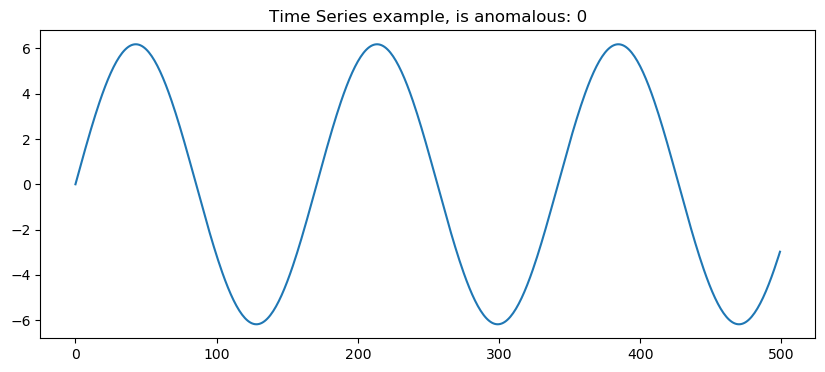

In [101]:
import matplotlib.pyplot as plt 
k = 1
plt.figure(figsize=(10,4))
plt.title(f'Time Series example, is anomalous: {data.Y[k]}')
plt.plot(data.X[k])

In [1]:
from data import * 
from model import *
data = Dataset()
data.to_torch()
data.train_val_test_split()
model = AttentionModel()
model.train_model(data=data)

Epoch  1 | Train Loss: 0.6856 | Val Loss: 0.6845
Epoch  2 | Train Loss: 0.6747 | Val Loss: 0.6844
Epoch  3 | Train Loss: 0.6699 | Val Loss: 0.6792
Epoch  4 | Train Loss: 0.6602 | Val Loss: 0.6610
Epoch  5 | Train Loss: 0.6017 | Val Loss: 0.5259
Epoch  6 | Train Loss: 0.3970 | Val Loss: 0.3081
Epoch  7 | Train Loss: 0.3170 | Val Loss: 0.2800
Epoch  8 | Train Loss: 0.2881 | Val Loss: 0.2899
Epoch  9 | Train Loss: 0.2466 | Val Loss: 0.2403
Epoch 10 | Train Loss: 0.2083 | Val Loss: 0.1579
Epoch 11 | Train Loss: 0.2018 | Val Loss: 0.2026
Epoch 12 | Train Loss: 0.1966 | Val Loss: 0.1735
Epoch 13 | Train Loss: 0.1562 | Val Loss: 0.2332
Epoch 14 | Train Loss: 0.1591 | Val Loss: 0.2771
Epoch 15 | Train Loss: 0.1705 | Val Loss: 0.1015
Epoch 16 | Train Loss: 0.1078 | Val Loss: 0.0984
Epoch 17 | Train Loss: 0.1053 | Val Loss: 0.0841
Epoch 18 | Train Loss: 0.0987 | Val Loss: 0.0769
Epoch 19 | Train Loss: 0.1282 | Val Loss: 0.0996
Epoch 20 | Train Loss: 0.0815 | Val Loss: 0.0868
Epoch 21 | Train Los

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_attention(sample_X, attention_weights, title="Attention over Time", save_path=None):
    """
    Visualizes attention weights over the input time series.

    Args:
        sample_X: torch.Tensor or np.array of shape (seq_len, 1)
        attention_weights: torch.Tensor or np.array of shape (seq_len,)
        title: plot title
        save_path: optional path to save the figure
    """
    if isinstance(sample_X, torch.Tensor):
        sample_X = sample_X.detach().cpu().numpy().squeeze()
    if isinstance(attention_weights, torch.Tensor):
        attention_weights = attention_weights.detach().cpu().numpy().squeeze()

    seq_len = len(sample_X)
    time_steps = np.arange(seq_len)

    fig, ax1 = plt.subplots(figsize=(10, 4))

    ax1.set_title(title)
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Signal", color='blue')
    ax1.plot(time_steps, sample_X, color='blue', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Attention", color='red')
    ax2.plot(time_steps, attention_weights*10, color='red', linestyle='--', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0, 1.1)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


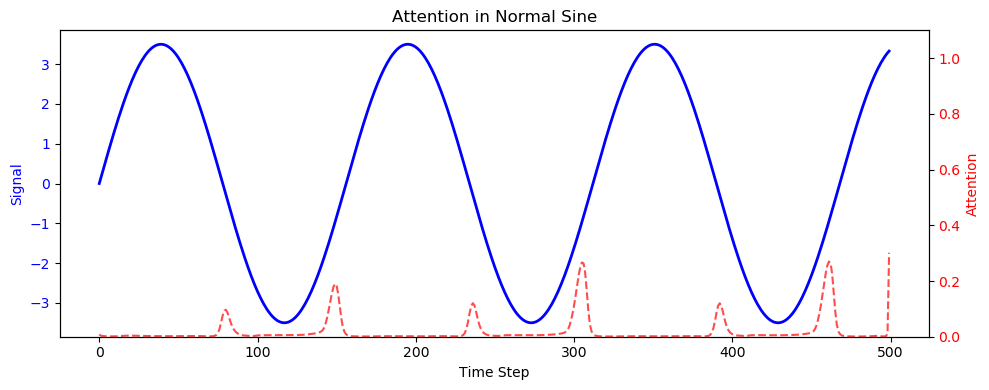

In [92]:
from utils import * 
model.eval()
k = 2
with torch.no_grad():
    for batch_X, batch_Y in data.val_loader:
        batch_X = batch_X.to('cpu')
        outputs, attn_weights = model(batch_X)

        # Let's plot the first sample in the batch
        plot_attention(batch_X[k], attn_weights[k], title="Attention in Normal Sine")
        break


In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

def evaluate_model(model, dataloader, device="cpu"):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_Y in dataloader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)

            outputs, _ = model(batch_X)
            preds = (outputs > 0.5).float()  # binary thresholding

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_Y.cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print(f"ROC AUC Score : {auc:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))


In [71]:
test_loader = data.test_loader
evaluate_model(model, test_loader, device='cpu')

Accuracy      : 0.9775
Precision     : 0.9855
Recall        : 0.9685
F1 Score      : 0.9769
ROC AUC Score : 0.9774

Confusion Matrix:
[[1002   14]
 [  31  953]]
